In [1]:
from modules.PageExtractor import *
from modules.utils import *

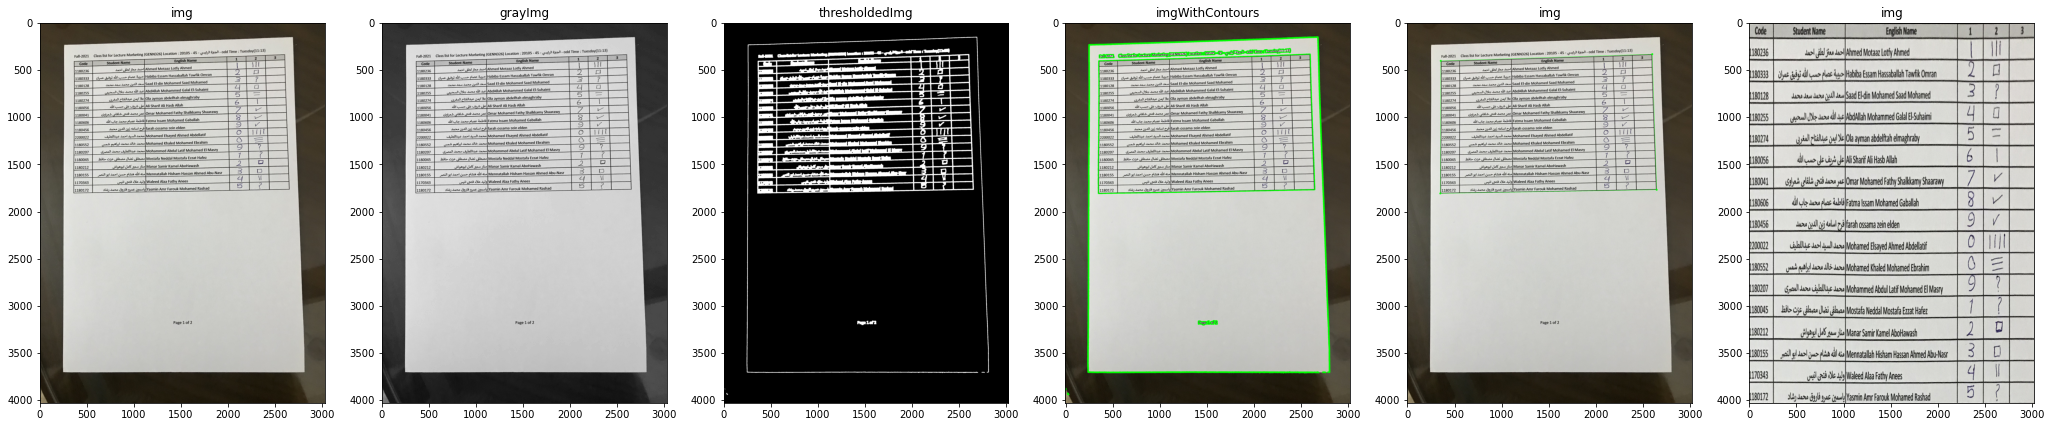

In [2]:
img=io.imread('./Data set/grade sheet/1.jpg')
imageArr=getPageWarped(img, thresh1=180)
show_images(imageArr,titles=['img','grayImg','thresholdedImg','imgWithContours','img','img'])
Table_Extracted=np.copy(imageArr[5])

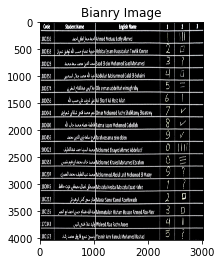

In [3]:
# print(np.max(Table_Extracted))
# print(np.shape(Table_Extracted))
# Table_Extracted=rgb2gray(Table_Extracted)
# Converting table to binary
thresh,img_bin = cv2.threshold(Table_Extracted,128,255,cv2.THRESH_BINARY)
# thresh,img_bin = cv2.threshold(Table_Extracted,128,255,cv2.THRESH_OTSU)

img_bin = 255-img_bin
show_images([img_bin],titles=['Bianry Image'])

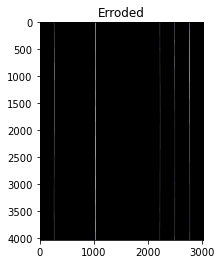

In [4]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, np.array(img).shape[1]//150))
# print(vertical_kernel)
eroded_image = cv2.erode(img_bin, vertical_kernel, iterations=10)
show_images([eroded_image],titles=['Erroded'])

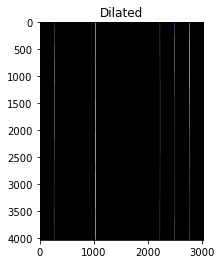

In [5]:
vertical_lines = cv2.dilate(eroded_image, vertical_kernel, iterations=10)
show_images([vertical_lines],titles=['Dilated'])

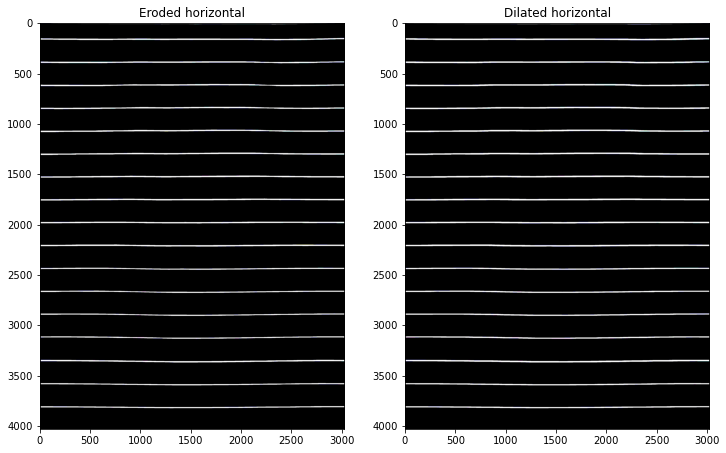

In [6]:
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))
image_2 = cv2.erode(img_bin, hor_kernel, iterations=10)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=10)
show_images([image_2,horizontal_lines],titles=['Eroded horizontal','Dilated horizontal'])

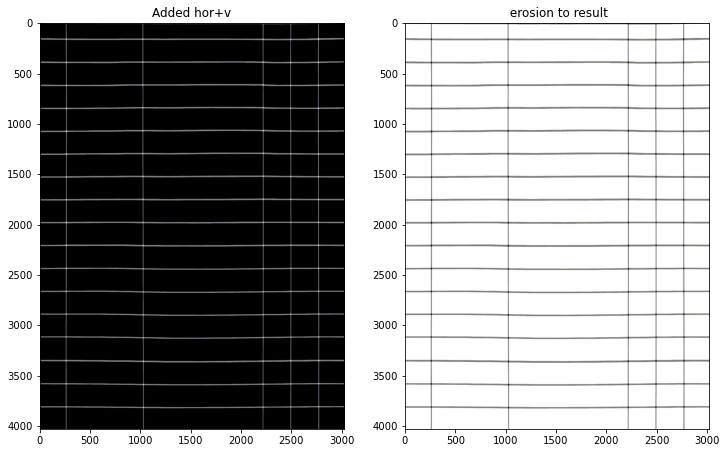

In [7]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines_2 = cv2.erode(~vertical_horizontal_lines, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)), iterations=3)
show_images([vertical_horizontal_lines,vertical_horizontal_lines_2],titles=['Added hor+v',' erosion to result'])

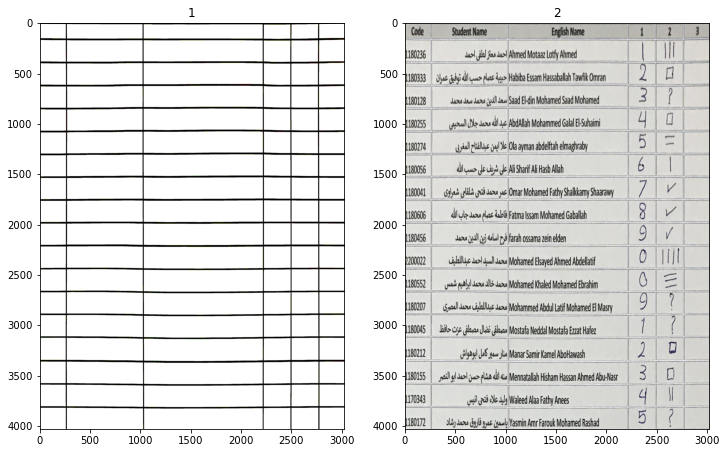

In [8]:
thresh, vertical_horizontal_lines_3 = cv2.threshold(vertical_horizontal_lines_2,128,255, cv2.THRESH_BINARY)
b_image = cv2.bitwise_not(cv2.bitwise_xor(Table_Extracted,vertical_horizontal_lines_3))
show_images([vertical_horizontal_lines_3,b_image],titles=['1','2'])

In [9]:
img1 = cv2.cvtColor(vertical_horizontal_lines_3, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(img1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [10]:
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
key=lambda x:x[1][1]))

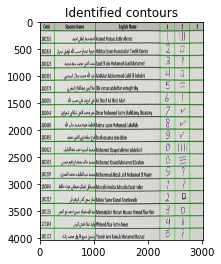

In [11]:
boxes = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if (w<1000 and h<500):
        image = cv2.rectangle(Table_Extracted,(x,y),(x+w,y+h),(0,255,0),2)
        boxes.append([x,y,w,h])
plotting = plt.imshow(image,cmap='gray')
plt.title("Identified contours")
plt.show()

In [12]:
rows=[]
columns=[]
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
mean = np.mean(heights)
print(mean)
columns.append(boxes[0])
previous=boxes[0]
for i in range(1,len(boxes)):
    if(boxes[i][1]<=previous[1]+mean/2):
        columns.append(boxes[i])
        previous=boxes[i]
        if(i==len(boxes)-1):
            rows.append(columns)
    else:
        rows.append(columns)
        columns=[]
        previous = boxes[i]
        columns.append(boxes[i])
print("Rows")
for row in rows:
    print(row)

210.7314814814815
Rows
[[2768, 5, 256, 146], [0, 5, 256, 149], [266, 9, 751, 146], [2492, 10, 266, 146], [2218, 14, 265, 144]]
[[2767, 165, 257, 218], [0, 168, 257, 216], [267, 170, 750, 215], [2492, 171, 265, 214], [2218, 173, 265, 214]]
[[2766, 394, 258, 217], [268, 398, 749, 216], [0, 399, 258, 214], [2492, 400, 265, 213], [2219, 400, 263, 214]]
[[2766, 624, 258, 215], [268, 625, 750, 216], [2218, 626, 264, 213], [2492, 629, 264, 211], [0, 629, 258, 212]]
[[2219, 851, 264, 214], [269, 851, 748, 217], [2766, 853, 258, 214], [2492, 855, 264, 212], [0, 856, 259, 213]]
[[2220, 1078, 263, 213], [268, 1079, 750, 215], [2767, 1081, 257, 212], [2493, 1082, 264, 211], [0, 1086, 259, 210]]
[[2220, 1304, 264, 213], [268, 1306, 749, 215], [2493, 1308, 264, 211], [2768, 1310, 256, 210], [0, 1312, 258, 211]]
[[2220, 1531, 264, 213], [268, 1533, 750, 214], [2494, 1534, 264, 211], [2768, 1536, 256, 210], [0, 1538, 258, 211]]
[[2220, 1760, 265, 212], [2494, 1761, 264, 211], [268, 1761, 751, 212], [2

In [13]:
total_cells=0
for i in range(len(row)):
    if len(row[i]) > total_cells:
        total_cells = len(row[i])
print(total_cells)

4


In [14]:
center = [int(rows[i][j][0]+rows[i][j][2]/2) for j in range(len(rows[i])) if rows[0]]
print(center)
center=np.array(center)
center.sort()
print(center)

[2351, 643, 2895, 2624, 129]
[ 129  643 2351 2624 2895]


In [20]:
boxes_list = []
for i in range(len(rows)):
    l=[]
    for k in range(total_cells):
        l.append([])
#     print(l)
    for j in range(len(rows[i])):
        diff = abs(center-(rows[i][j][0]+rows[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
#         print(indexing)
        l[indexing-1].append(rows[i][j])
    boxes_list.append(l)
for box in boxes_list:
    print(box)

[[[266, 9, 751, 146]], [[2218, 14, 265, 144]], [[2492, 10, 266, 146]], [[2768, 5, 256, 146], [0, 5, 256, 149]]]
[[[267, 170, 750, 215]], [[2218, 173, 265, 214]], [[2492, 171, 265, 214]], [[2767, 165, 257, 218], [0, 168, 257, 216]]]
[[[268, 398, 749, 216]], [[2219, 400, 263, 214]], [[2492, 400, 265, 213]], [[2766, 394, 258, 217], [0, 399, 258, 214]]]
[[[268, 625, 750, 216]], [[2218, 626, 264, 213]], [[2492, 629, 264, 211]], [[2766, 624, 258, 215], [0, 629, 258, 212]]]
[[[269, 851, 748, 217]], [[2219, 851, 264, 214]], [[2492, 855, 264, 212]], [[2766, 853, 258, 214], [0, 856, 259, 213]]]
[[[268, 1079, 750, 215]], [[2220, 1078, 263, 213]], [[2493, 1082, 264, 211]], [[2767, 1081, 257, 212], [0, 1086, 259, 210]]]
[[[268, 1306, 749, 215]], [[2220, 1304, 264, 213]], [[2493, 1308, 264, 211]], [[2768, 1310, 256, 210], [0, 1312, 258, 211]]]
[[[268, 1533, 750, 214]], [[2220, 1531, 264, 213]], [[2494, 1534, 264, 211]], [[2768, 1536, 256, 210], [0, 1538, 258, 211]]]
[[[268, 1761, 751, 212]], [[2220,

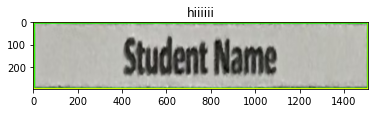

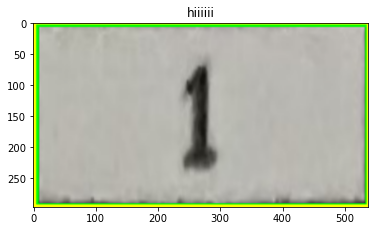

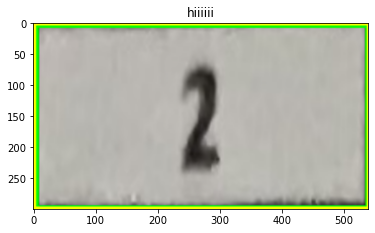

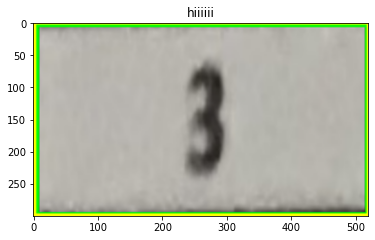

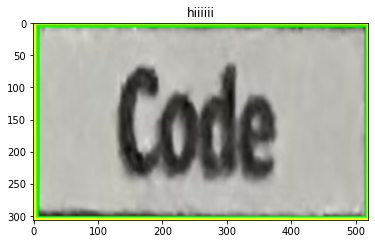

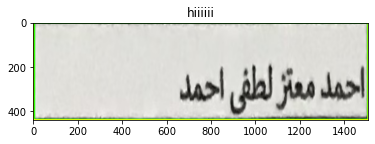

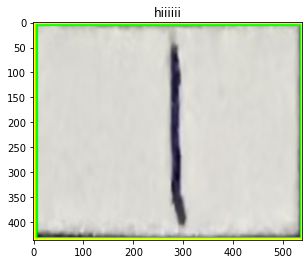

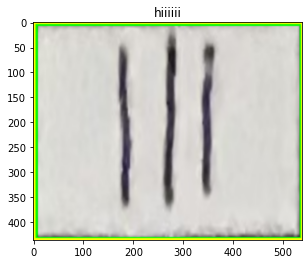

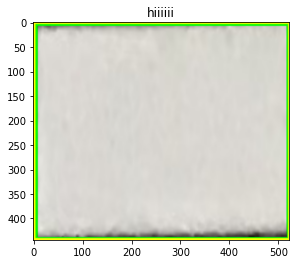

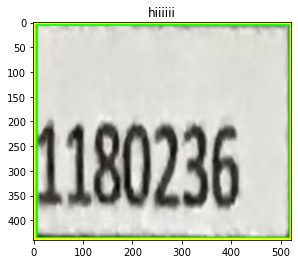

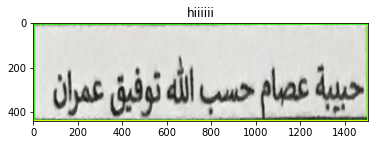

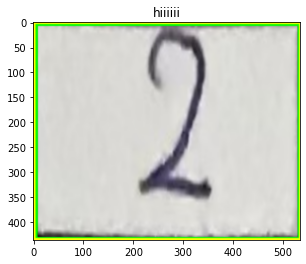

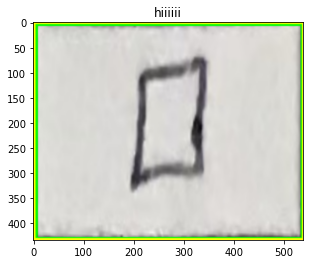

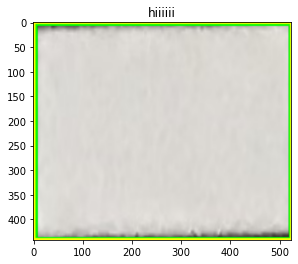

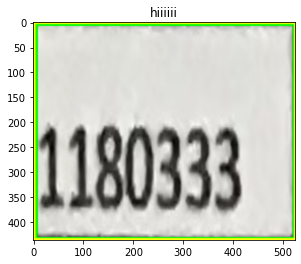

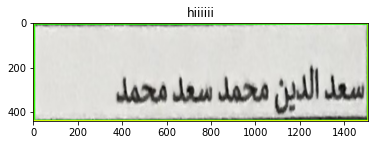

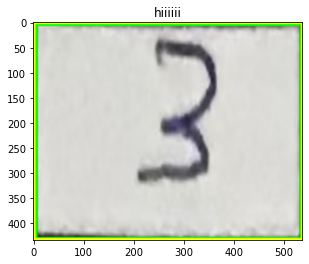

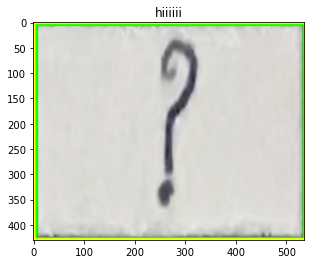

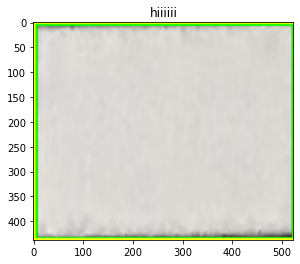

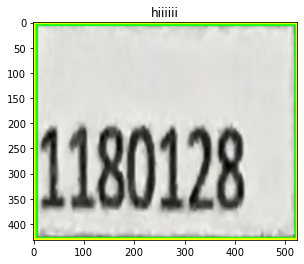

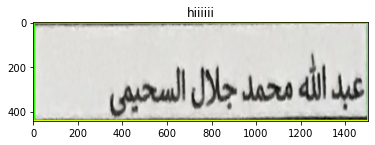

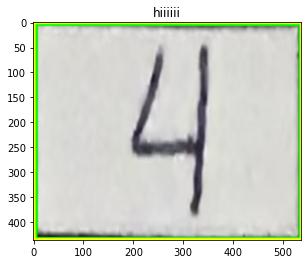

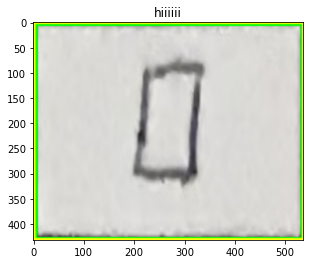

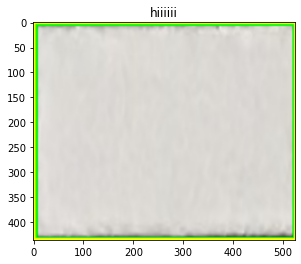

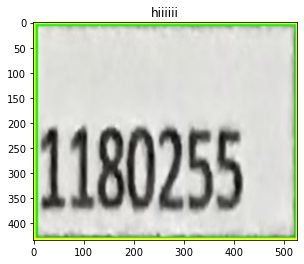

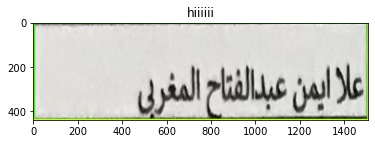

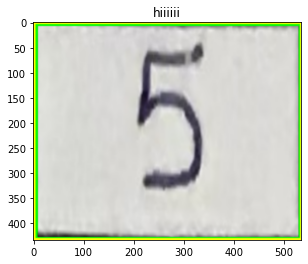

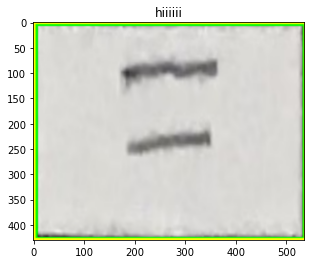

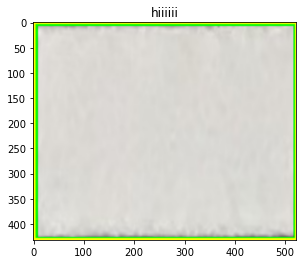

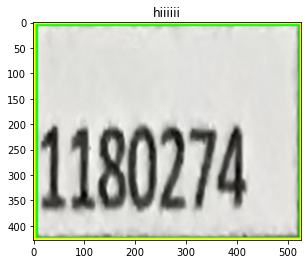

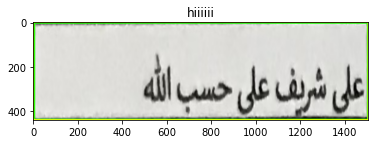

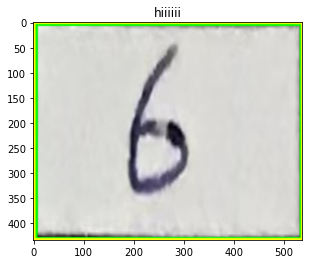

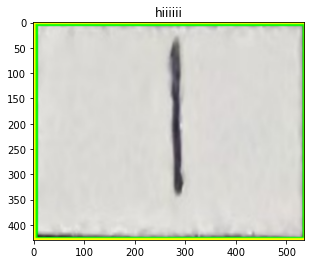

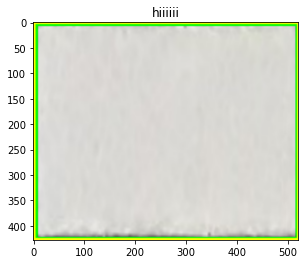

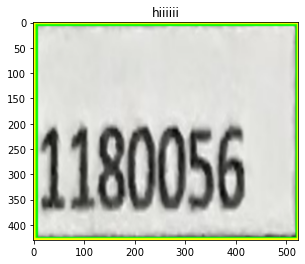

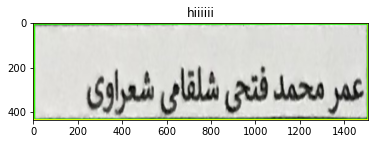

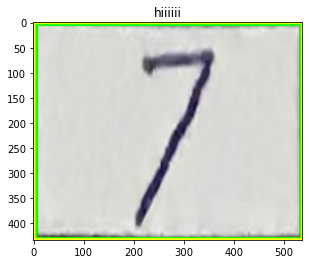

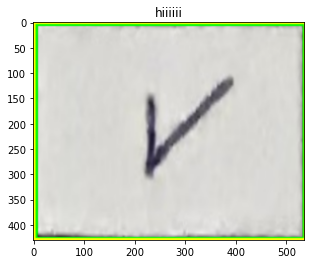

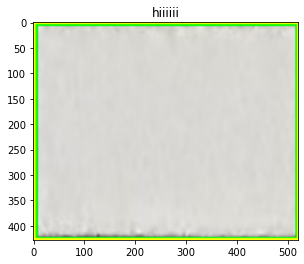

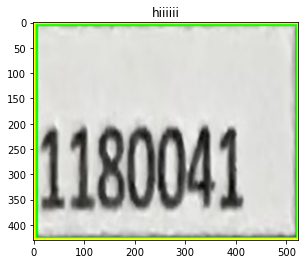

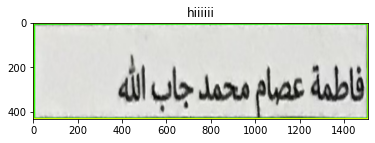

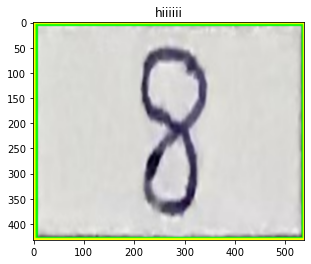

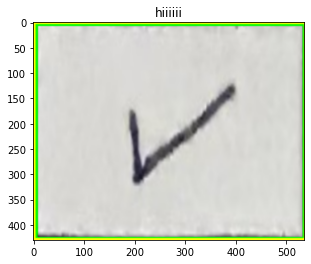

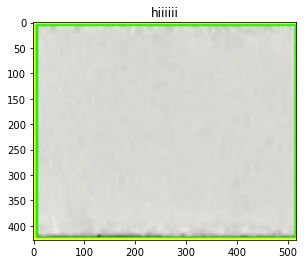

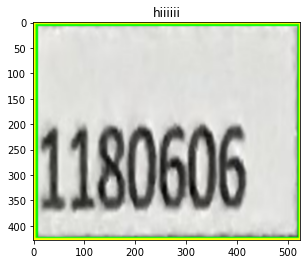

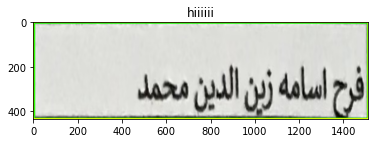

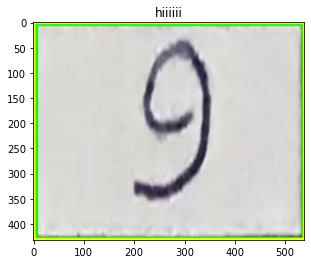

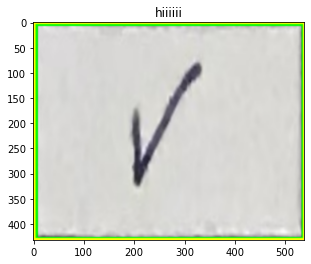

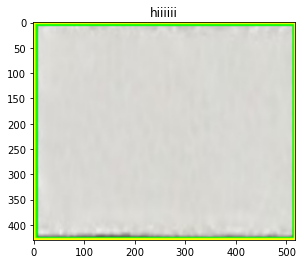

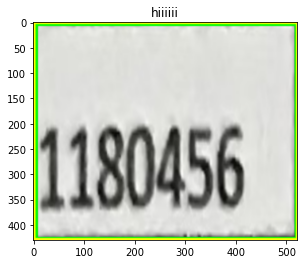

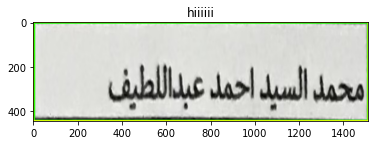

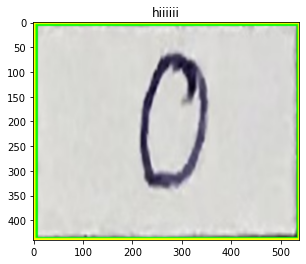

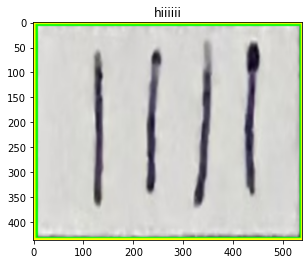

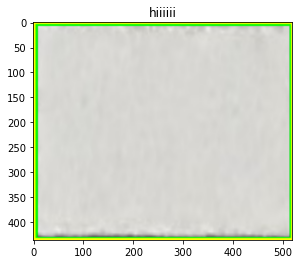

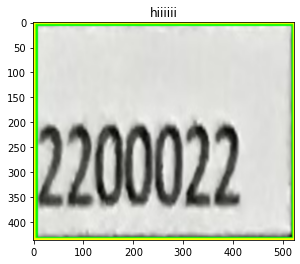

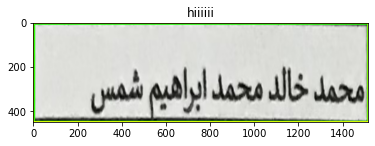

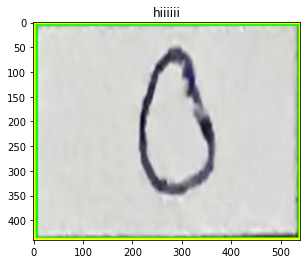

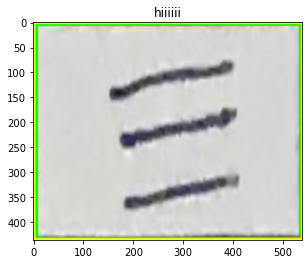

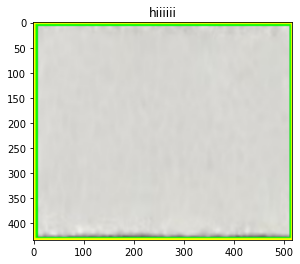

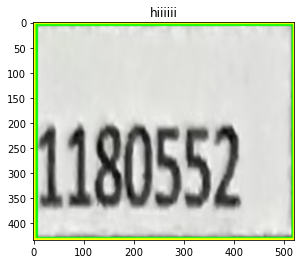

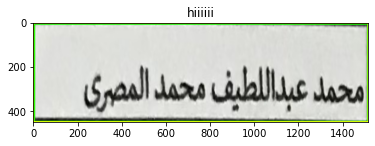

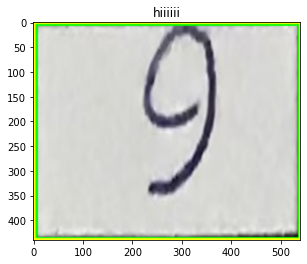

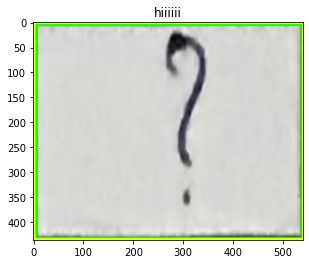

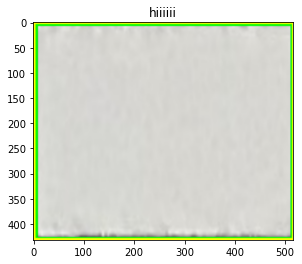

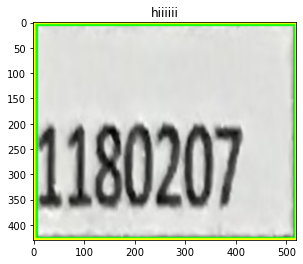

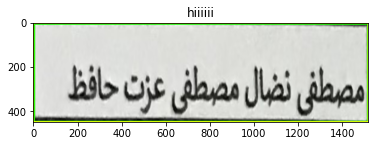

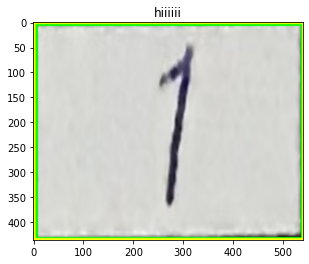

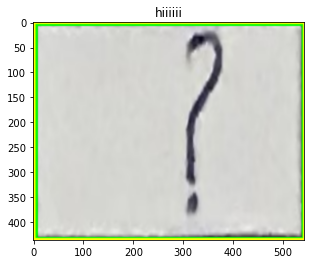

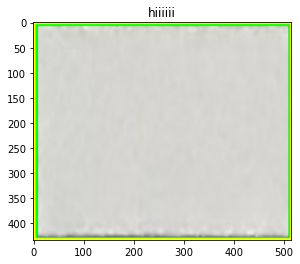

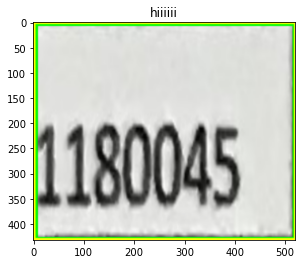

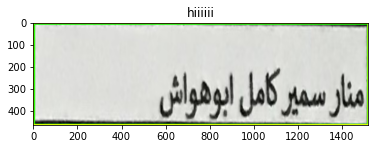

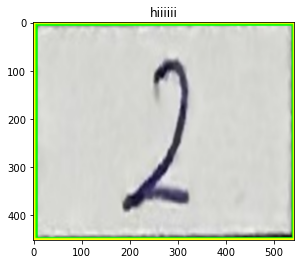

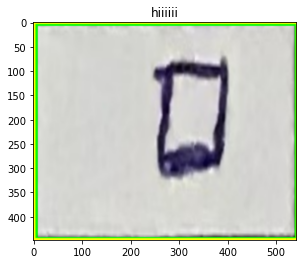

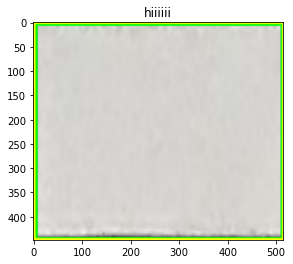

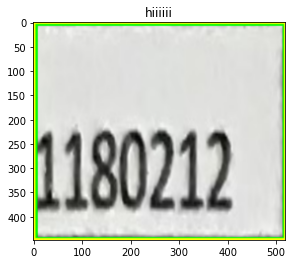

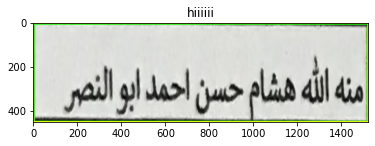

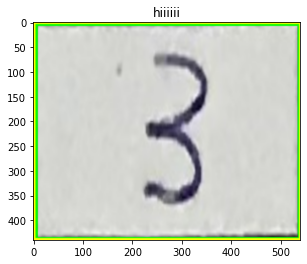

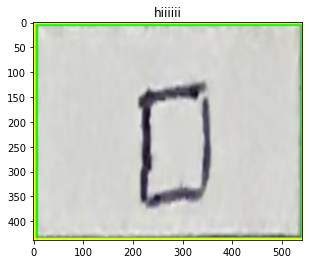

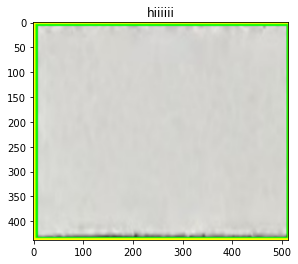

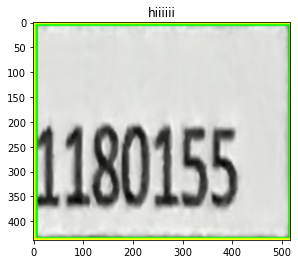

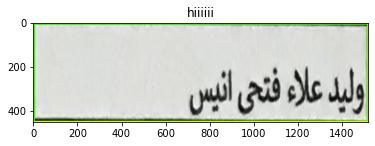

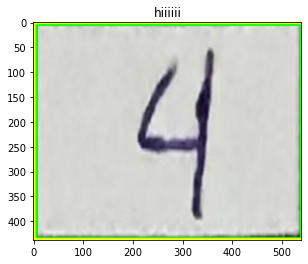

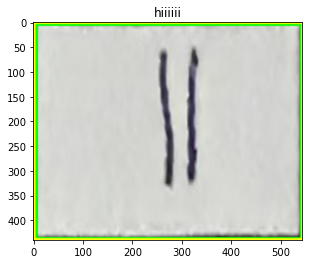

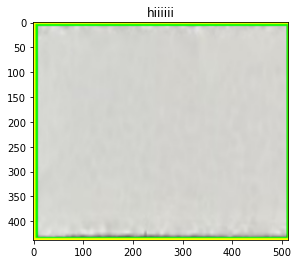

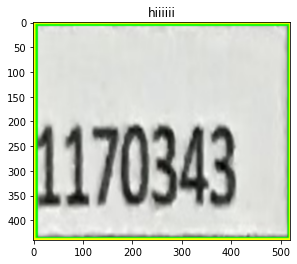

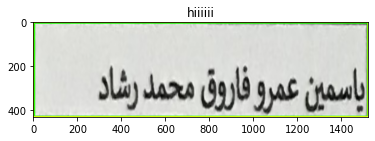

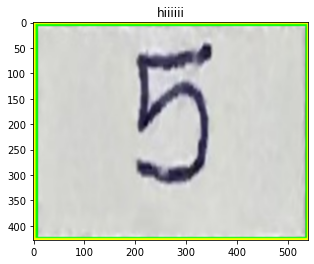

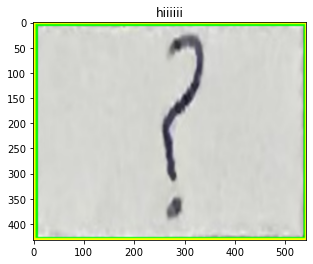

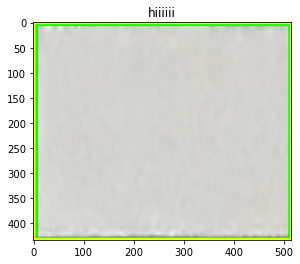

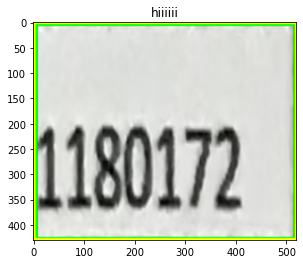

In [24]:
dataframe_final=[]
for i in range(len(boxes_list)):
    for j in range(len(boxes_list[i])):
        s=''
        if(len(boxes_list[i][j])==0):
            dataframe_final.append(' ')
        else:
            for k in range(len(boxes_list[i][j])):
                y,x,w,h = boxes_list[i][j][k][0],boxes_list[i][j][k][1], boxes_list[i][j][k][2],boxes_list[i][j][k][3]
                roi = image[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(roi,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                show_images([erosion],titles=['hiiiiii'])
#                 out = pytesseract.image_to_string(erosion)
#                 if(len(out)==0):
#                     out = pytesseract.image_to_string(erosion)
#                 s = s +" "+ out
#             dataframe_final.append(s)
# print(dataframe_final)

In [ ]:
arr = np.array(dataframe_final)

In [ ]:
import pandas as pd
dataframe = pd.DataFrame(arr.reshape(len(rows), total_cells))
data = dataframe.style.set_properties(align="left")
#print(data)
#print(dataframe)
d=[]
for i in range(0,len(rows)):
    for j in range(0,total_cells):
        print(dataframe[i][j],end=" ")
print()

In [ ]:
dataframe.to_csv("output.csv")